<a href="https://colab.research.google.com/github/dsubham/VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Autoencoders**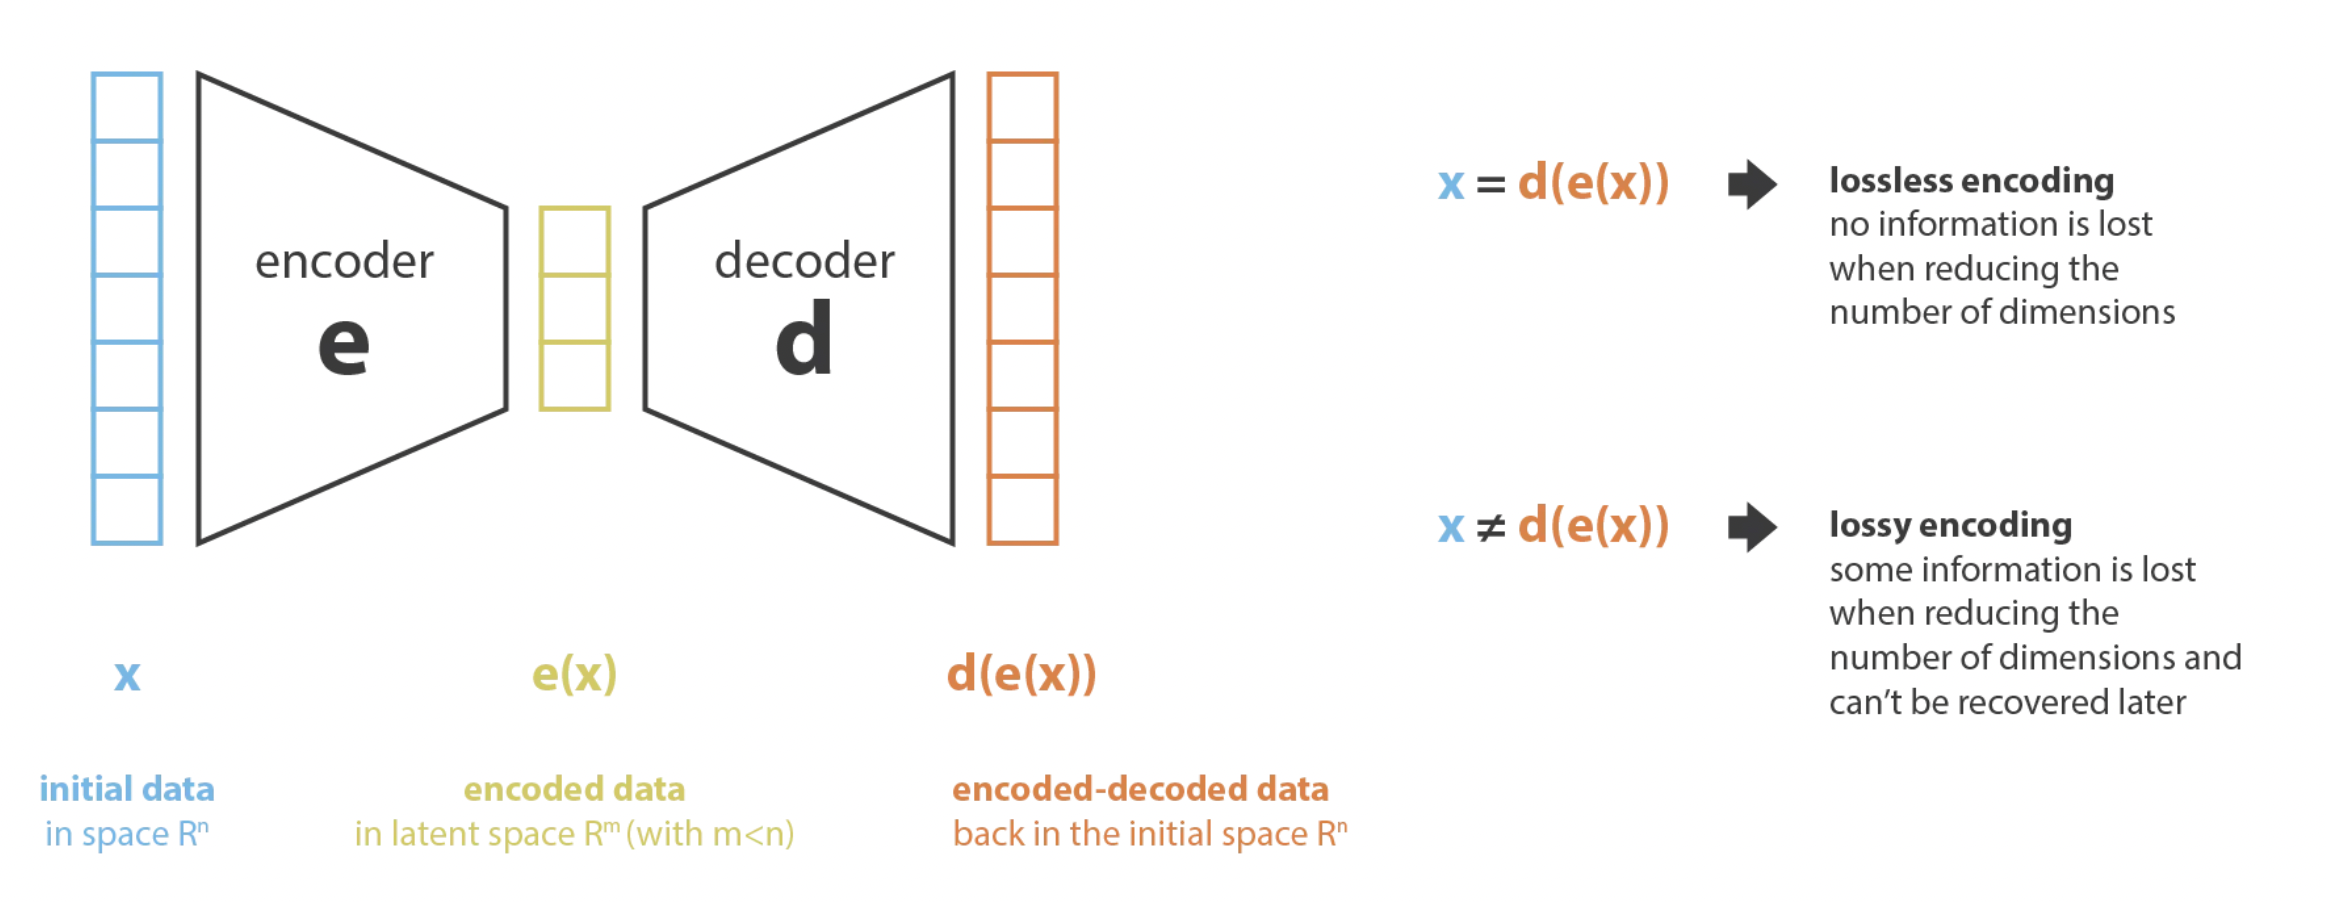



1. What is an Autoencoder?
2. Autoencoder and content generation
3. Variational Autoencoder vs Autoencoder
4. VAE process
5. Math involved in the process
6. Application of VAE





# **Autoencoder**

Autoencoder consists of an encoder and a decoder as neural networks and to learn the best encoding-decoding scheme using an iterative optimisation process. So, at each iteration we feed the autoencoder architecture with some data, we compare the encoded-decoded output with the initial data and backpropagate the error through the architecture to update the weights of the networks.

Thus, the overall autoencoder architecture (encoder+decoder) creates a bottleneck for data that ensures only the main structured part of the information can go through and be reconstructed.

The family E of considered encoders is defined by the encoder network architecture, the family D of considered decoders is defined by the decoder network architecture and the search of encoder and decoder that minimise the reconstruction error is done by gradient descent over the parameters of these networks.

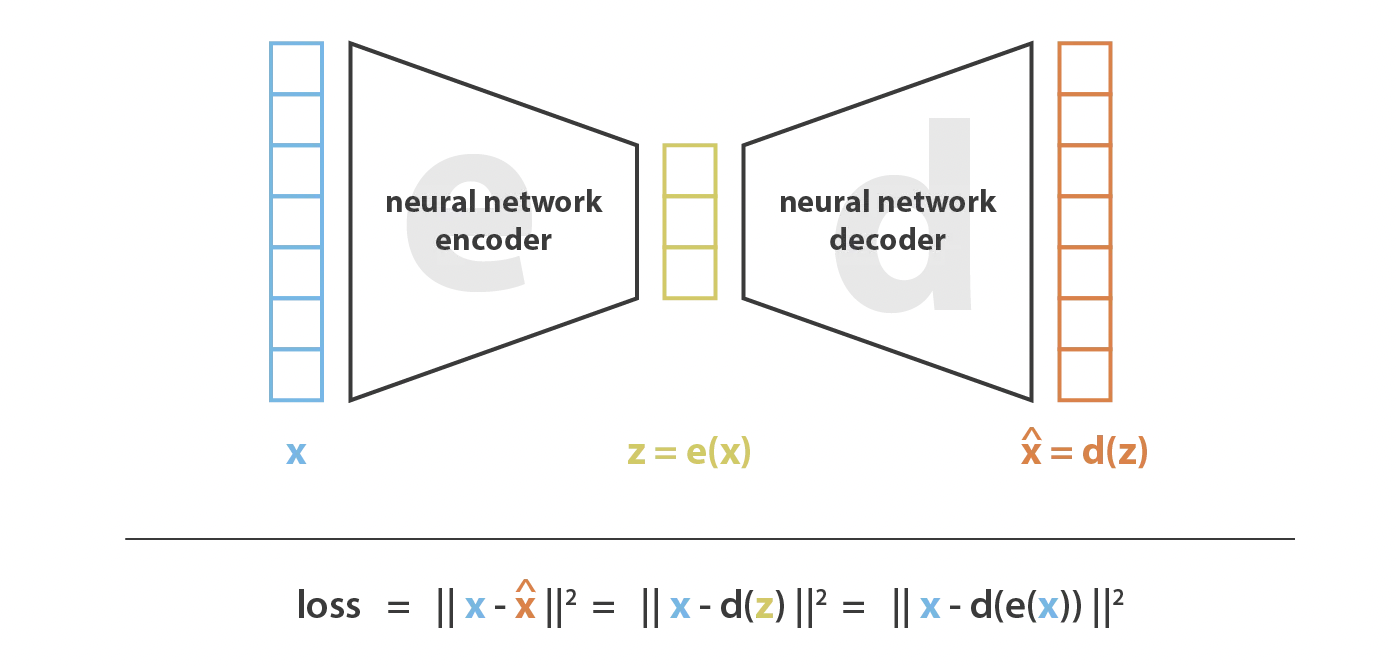

# **Autoencoder and content generation**

In a ideal case scenario, if the latent space (encoded space) is regular enough (well “organized” by the encoder during the training process), we could take a point randomly from that latent space and decode it to get a new content.

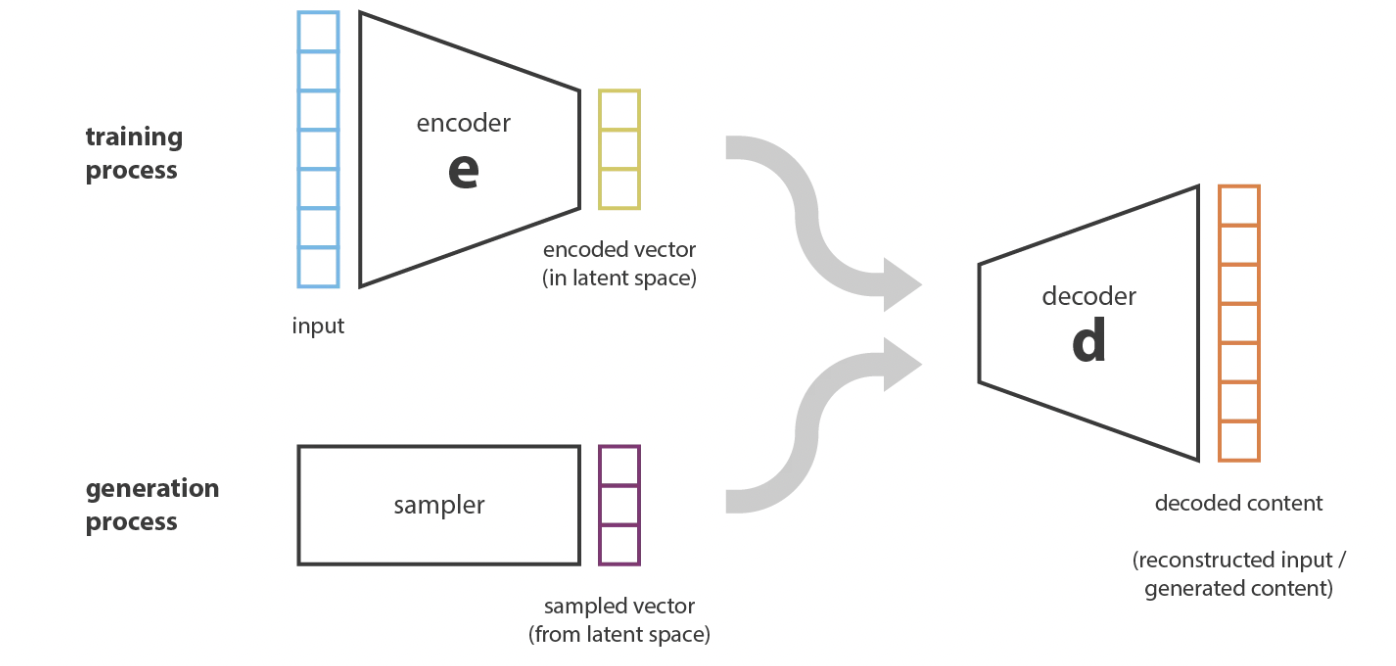

However, the regularity of the latent space for autoencoders is a difficult point that depends on the distribution of the data in the initial space, the dimension of the latent space and the architecture of the encoder. So, it is difficult to ensure, a priori, that the encoder will organize the latent space in a smart way compatible with the generative process above

For example, consider an encoder and a decoder powerful enough to put any N initial training data onto the real axis (each data point being encoded as a real value) and decode them without any reconstruction loss. In such case, the high degree of freedom of the autoencoder that makes possible to encode and decode with no information loss (despite the low dimensionality of the latent space) leads to a severe overfitting implying that some points of the latent space will give meaningless content once decoded

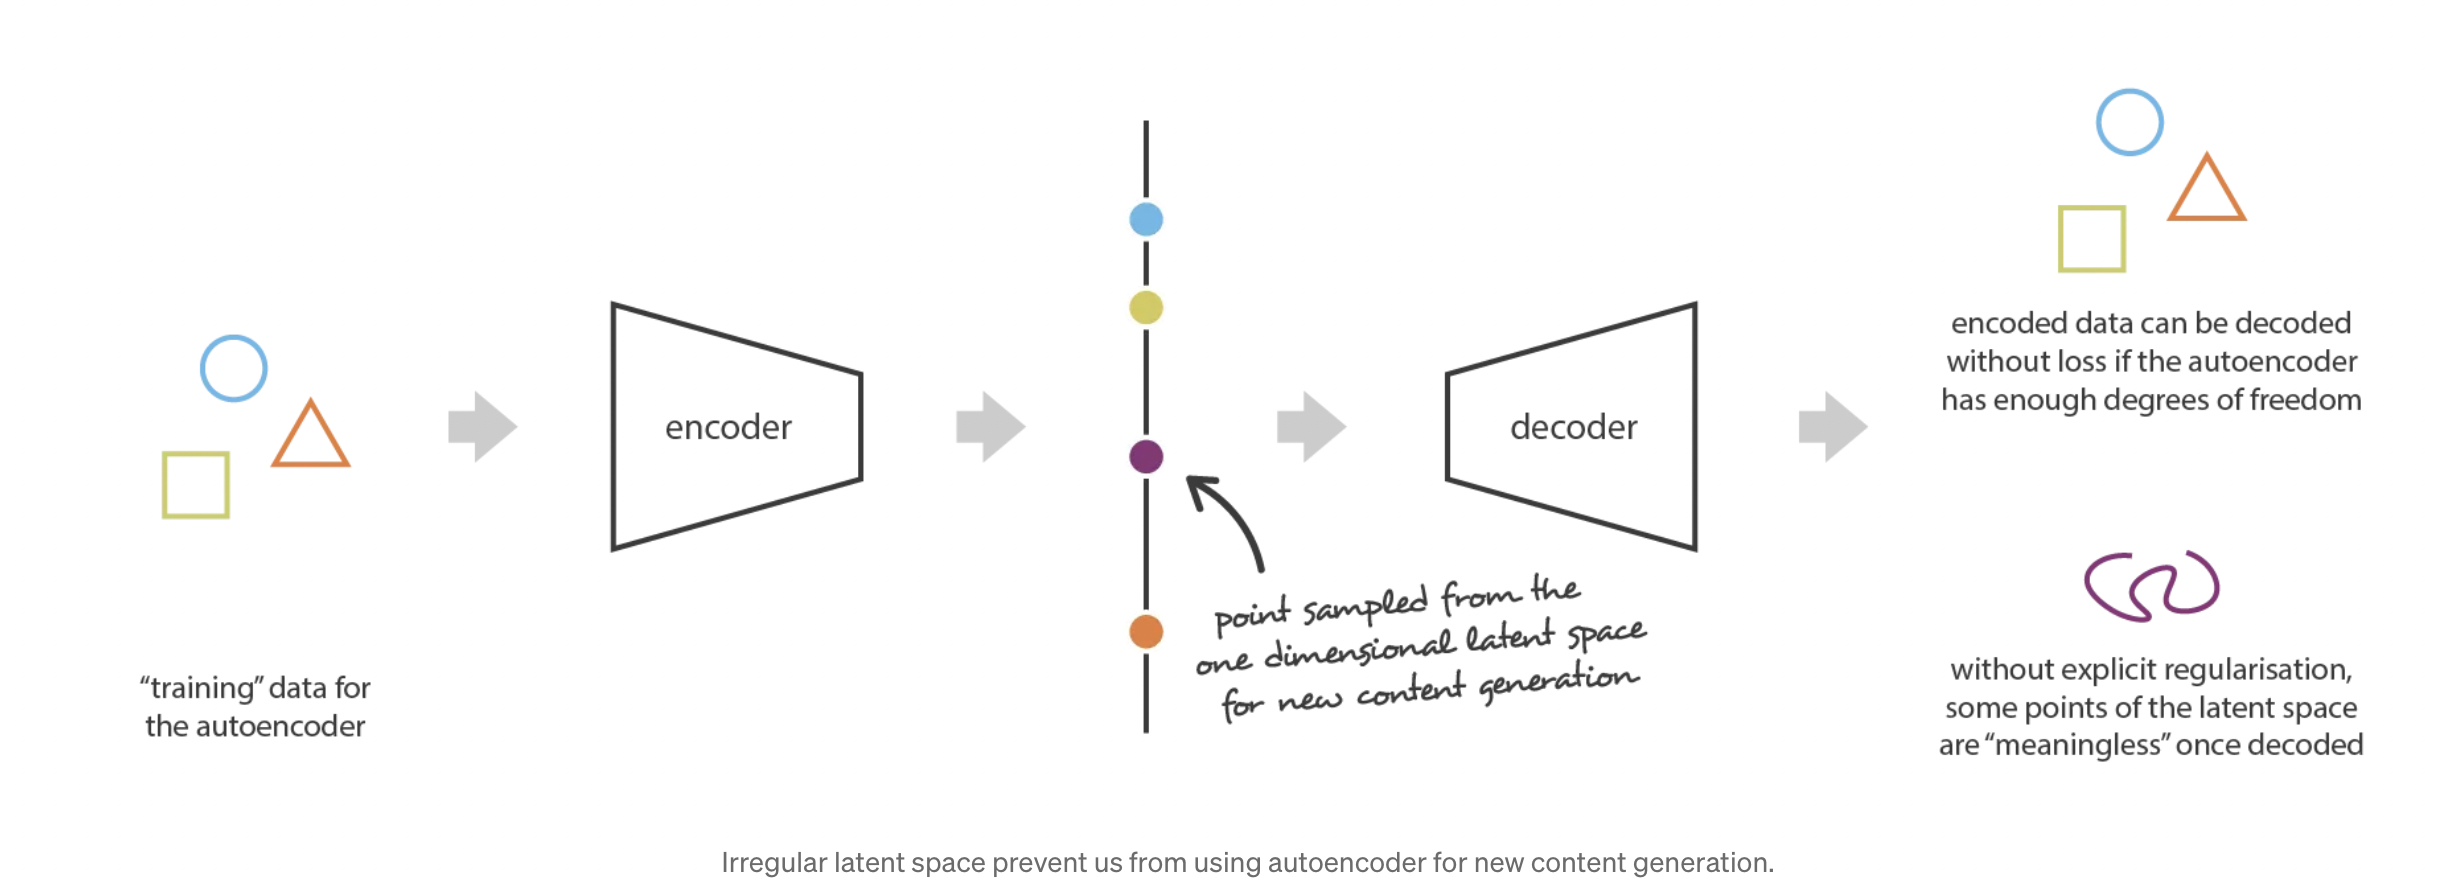

The lack of structure among the encoded data into the latent space is pretty normal. Ideally, nothing in the task the autoencoder is trained for enforce to get such organisation: the autoencoder is solely trained to encode and decode with as few loss as possible, no matter how the latent space is organised.

Thus, we need to regularize the latent space which forms the foundation of Variational Autoencoders

# **Variational Autoencoder vs Autoencoder**

A variational autoencoder can be defined as being an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has properties that enable generative process.

Similar to a standard autoencoder, a variational autoencoder is composed of both an encoder and a decoder and that is trained to minimise the reconstruction error between the encoded-decoded data and the initial data.

However, in order to introduce some regularisation of the latent space, instead of encoding an input as a single point, we encode it as a distribution over the latent space

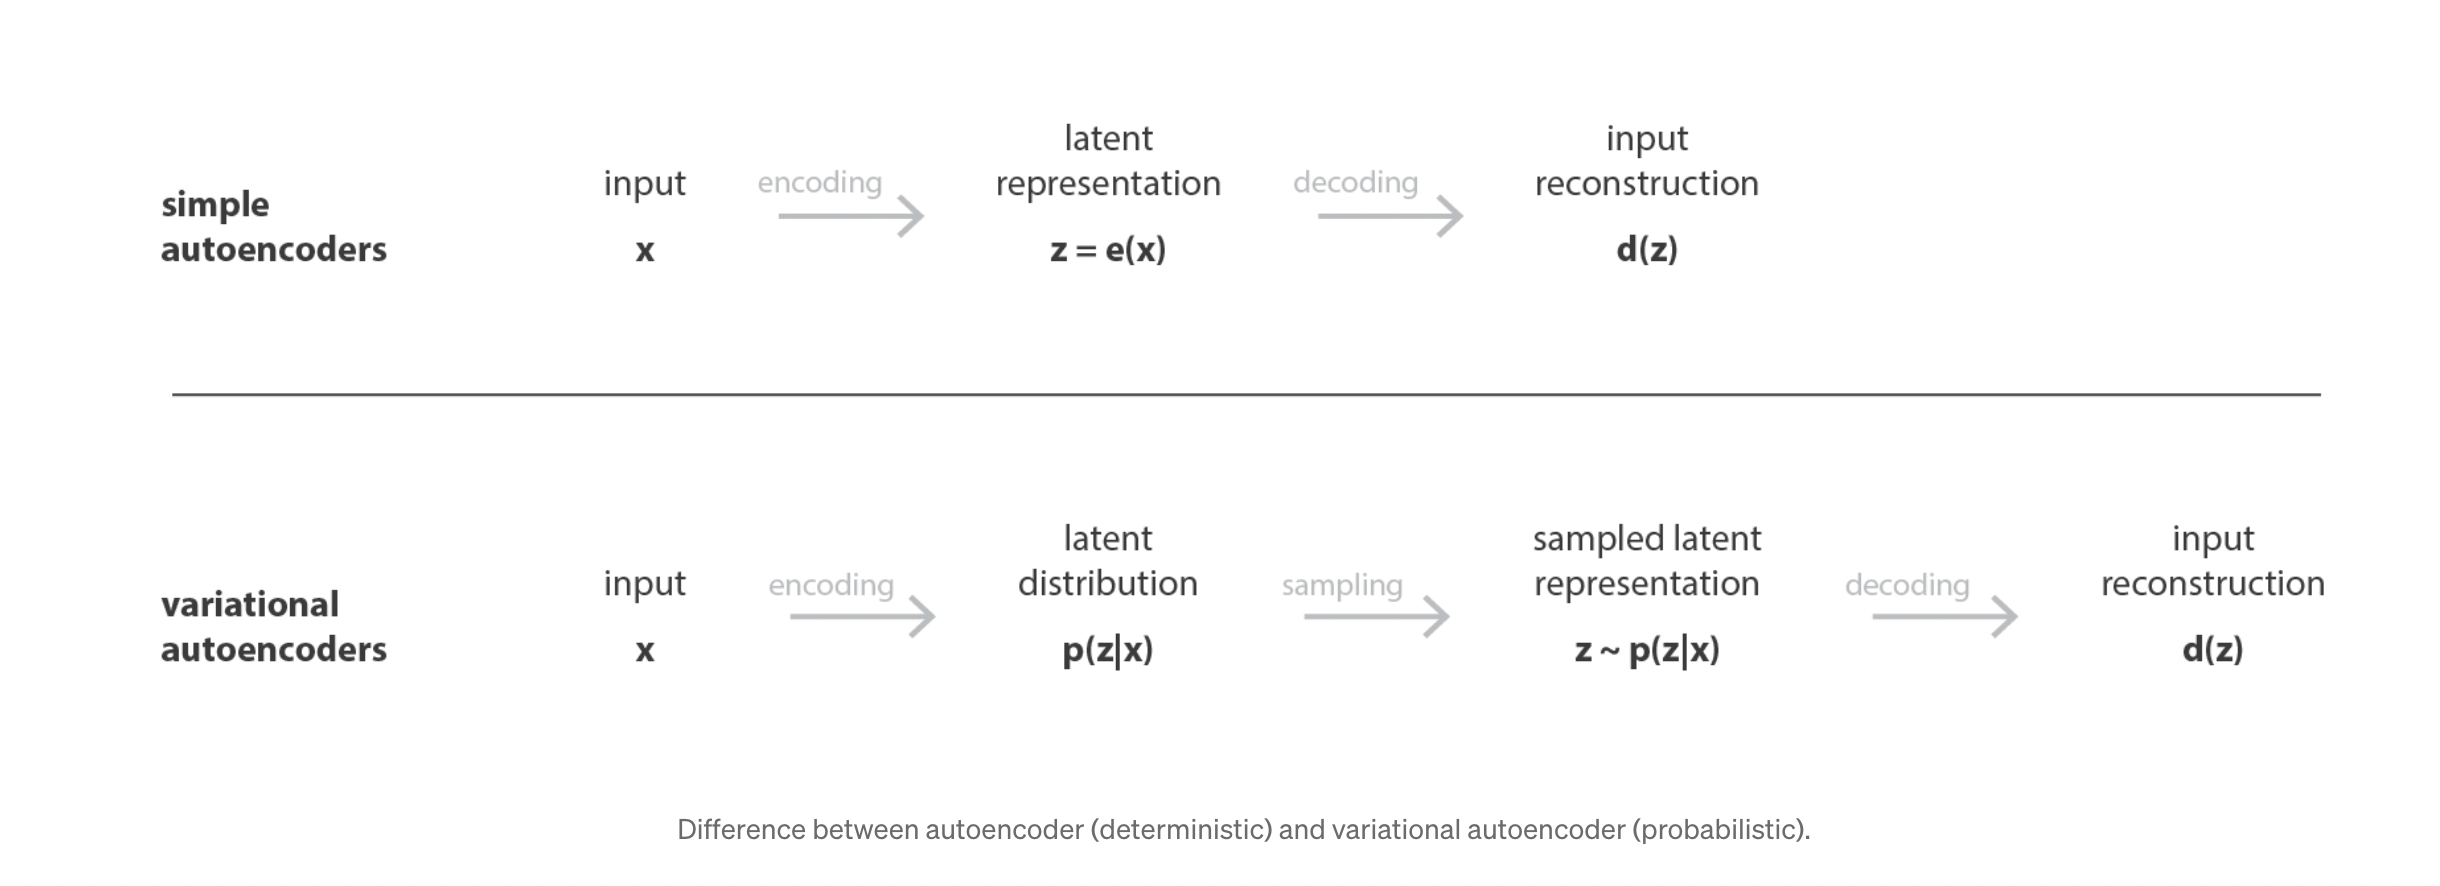

# **VAE process**

In practice, the encoded distributions are chosen to be normal so that the encoder can be trained to return the mean and the covariance matrix that describe these Gaussians.

Thus, the loss function that is minimised when training a VAE is composed of a “reconstruction term” (on the final layer), and a “regularisation term” (on the latent layer), that tends to regularise the organisation of the latent space by making the distributions returned by the encoder close to a standard normal distribution. That regularisation term is expressed as the Kulback-Leibler divergence between the returned distribution and a standard Gaussian



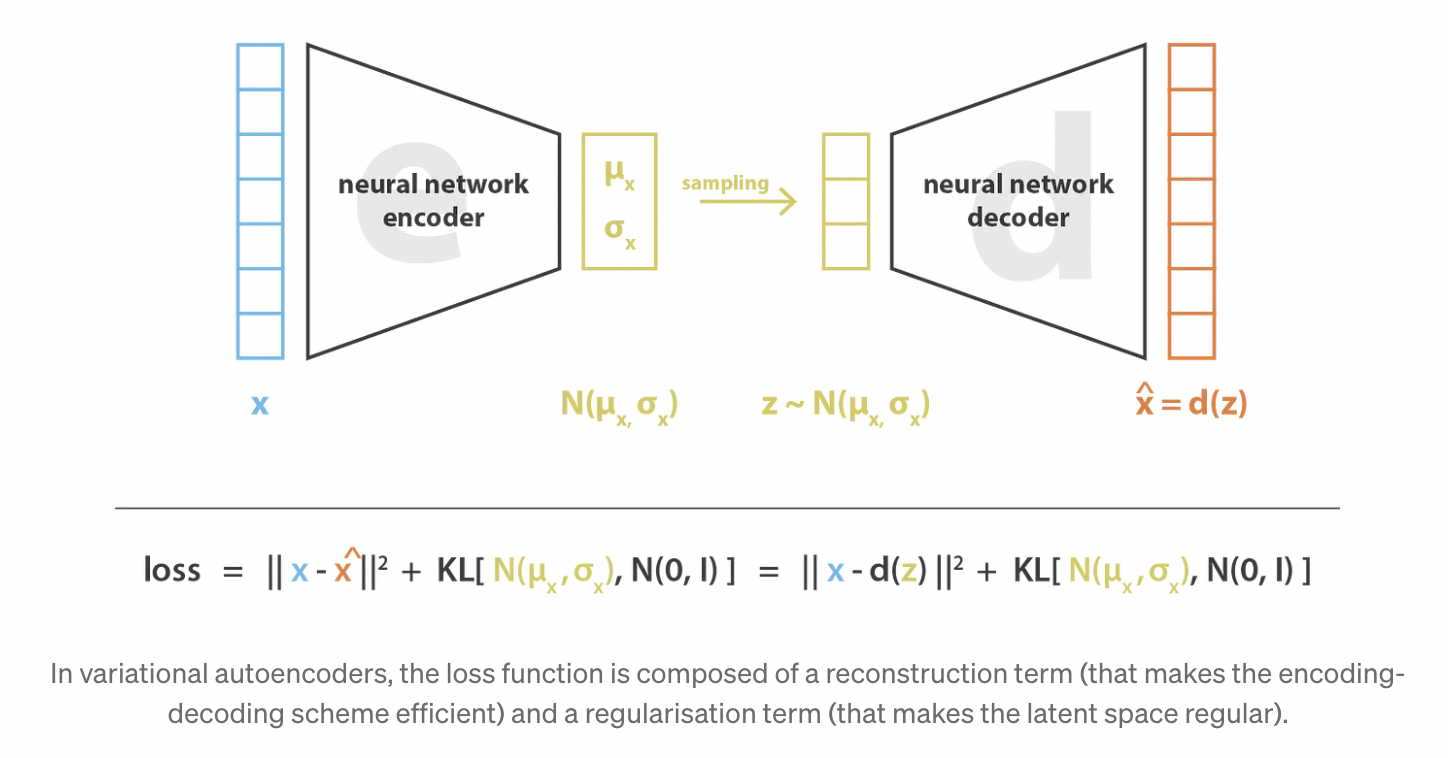

The regularity that is expected from the latent space in order to make generative process possible can be expressed through two main properties: continuity (two close points in the latent space should not give two completely different contents once decoded) and completeness (for a chosen distribution, a point sampled from the latent space should give “meaningful” content once decoded).

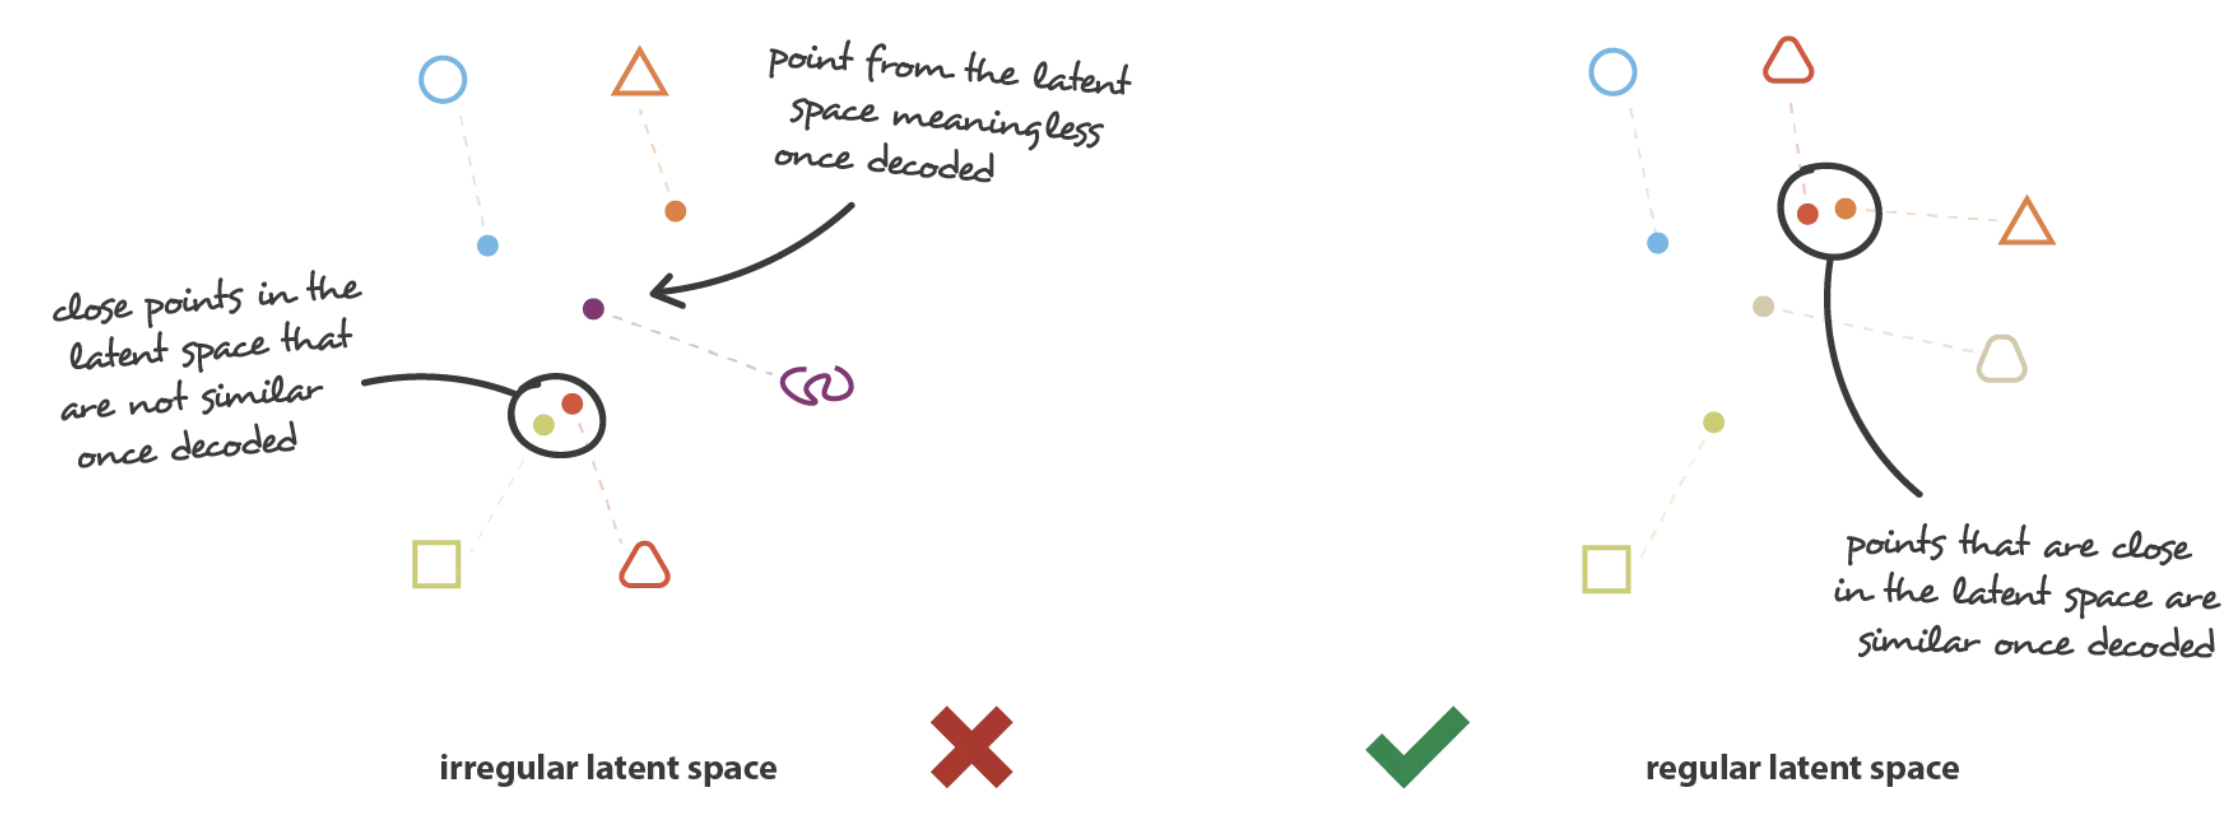

In case of VAE, what happens if we do not regularize?

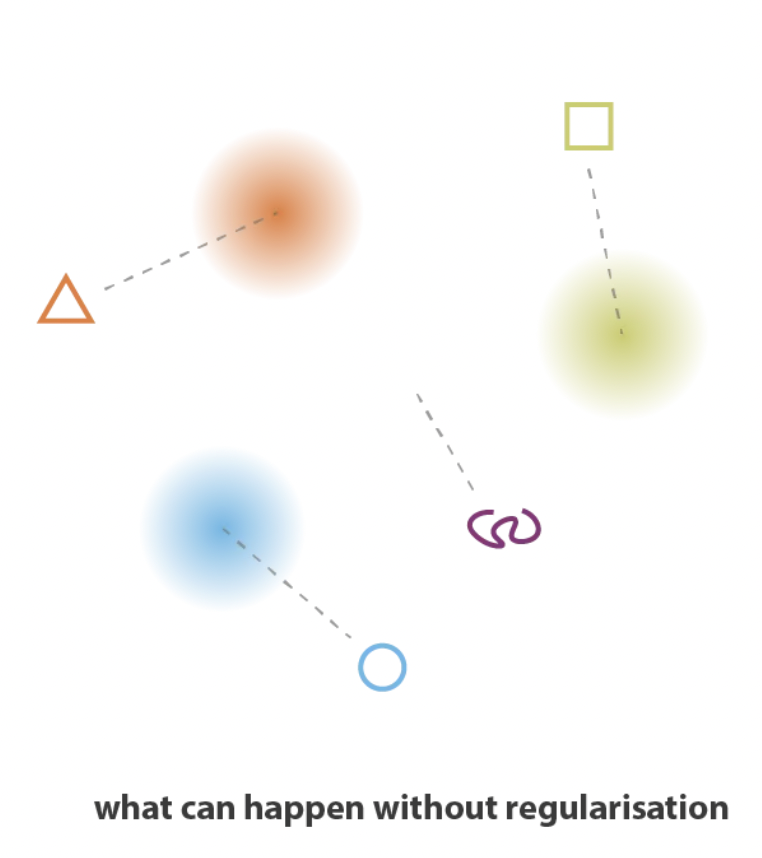

So, we try to regularize the latent space with respect to the mean and covariance. This is done by enforcing distributions to be close to a standard normal distribution (centred and reduced). This way, we require the covariance matrices to be close to the identity, and the mean to be close to 0, preventing encoded distributions to be too far apart from each others

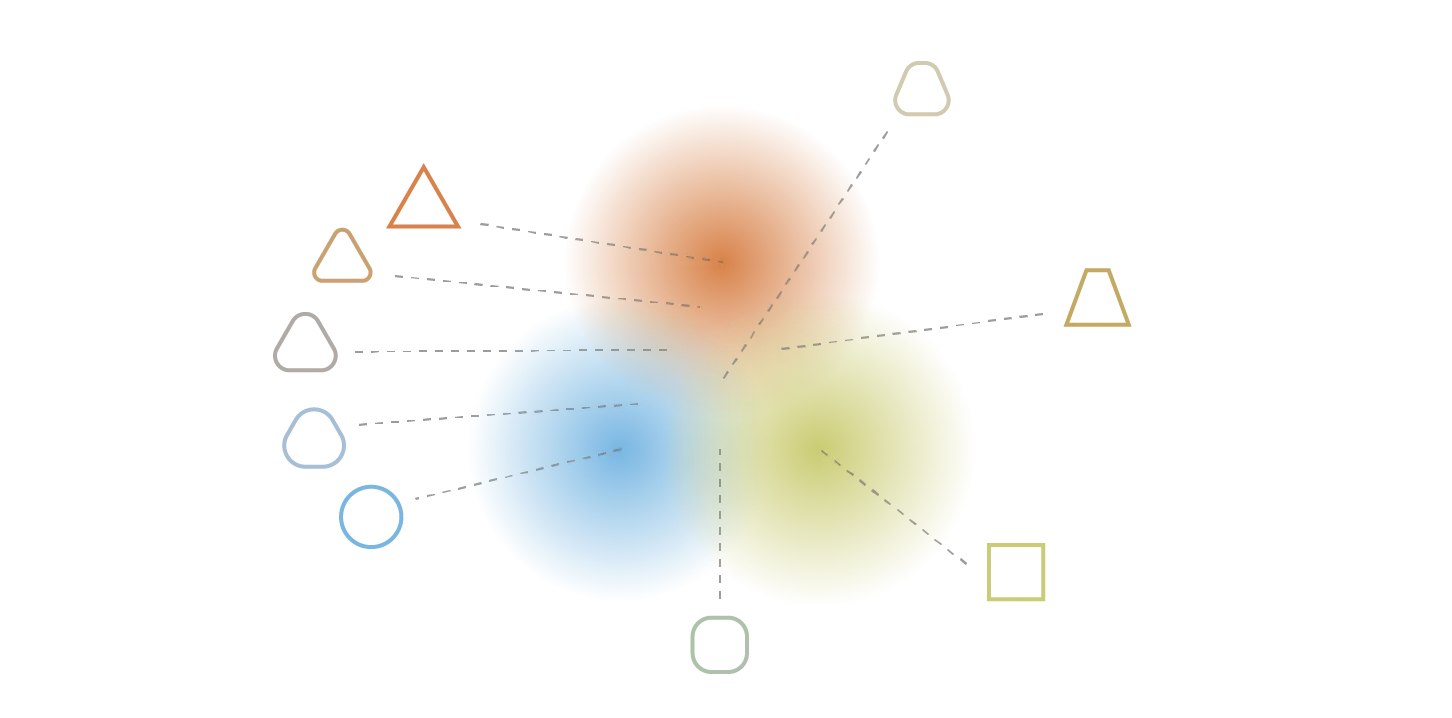

# **Math involved in the process**

Let x be the variable that represents our data and assume that x is generated from a latent variable z (the encoded representation) that is not directly observed. Thus, for each data point, the following two steps are taken up for generation:


1. A latent representation z is sampled from the prior distribution p(z)
2. The data x is sampled from the conditional likelihood distribution p(x|z)

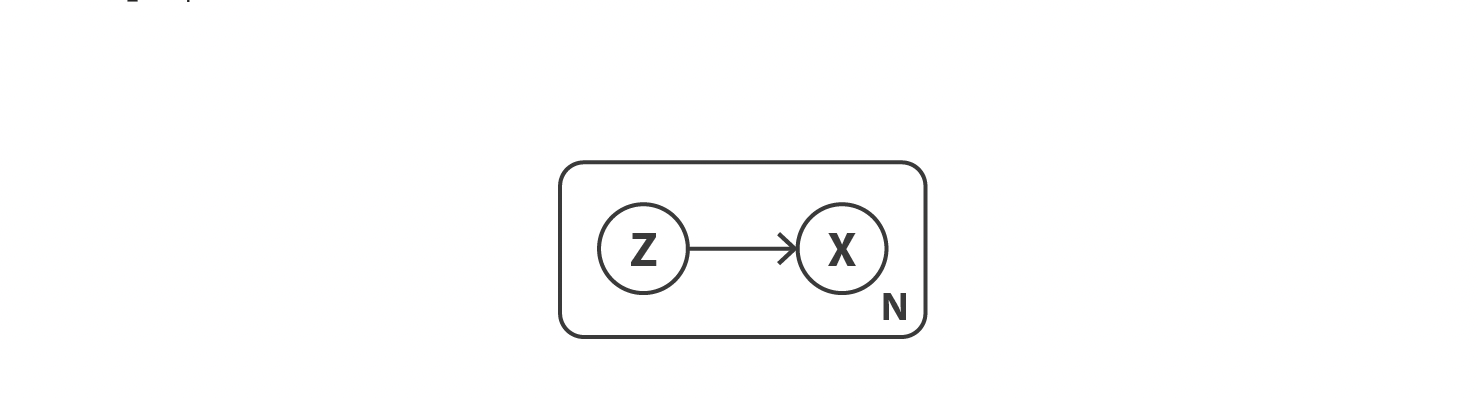

Using Bayes Theorem, the probabilities can be linked as follows:

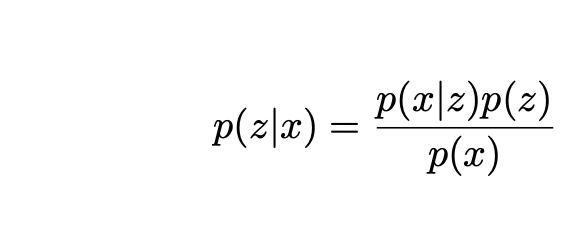

Assumptions:



*   p(z) is a standard Gaussian distribution and that p(x|z) is a Gaussian distribution whose mean is defined by a deterministic function f of the variable of z and whose covariance matrix has the form of a positive constant c that multiplies the identity matrix I
*   he function f is assumed to belong to a family of functions denoted by F.

Thus, we will have:

p(z) = N(0,I)
p(x/z) = N(f(x),cI) where f is subset of F and c>0

We are looking for an encoding-decoding scheme as efficient as possible and, then, we want to choose the function f that maximises the expected log-likelihood of x given z when z is sampled from q*_x(z). In other words, for a given input x, we want to maximise the probability to have x̂ = x when we sample z from the distribution q*_x(z) and then sample x̂ from the distribution p(x|z). Thus, we are looking for the optimal f* such that


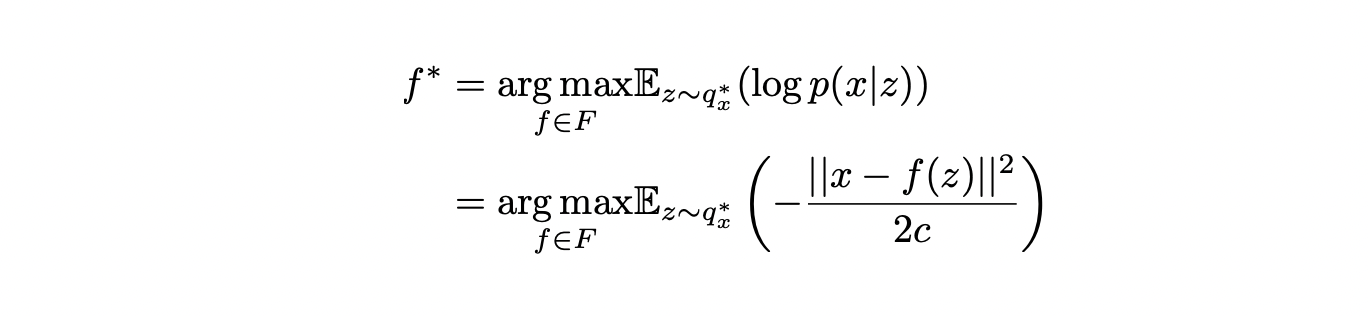

Now, we are going to approximate p(z|x) by a Gaussian distribution q_x(z) (this is known as variational interference) whose mean and covariance are defined by two functions, g and h, of the parameter x. These two functions are supposed to belong, respectively, to the families of functions G and H that will be specified later but that are supposed to be parametrised. Thus we can denote

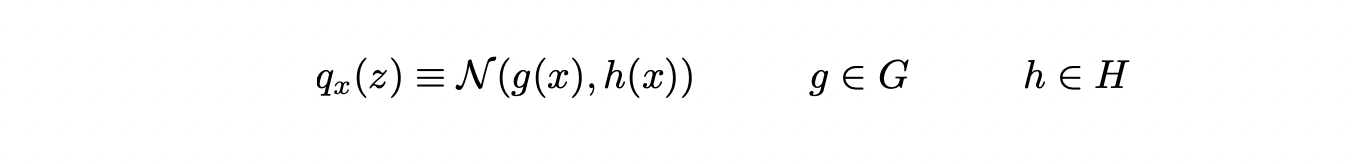

So, now we to find the best approximation among this family by optimising the functions g and h (in fact, their parameters) to minimise the Kullback-Leibler divergence between the approximation and the target p(z|x). In other words, we are looking for the optimal g* and h* such that

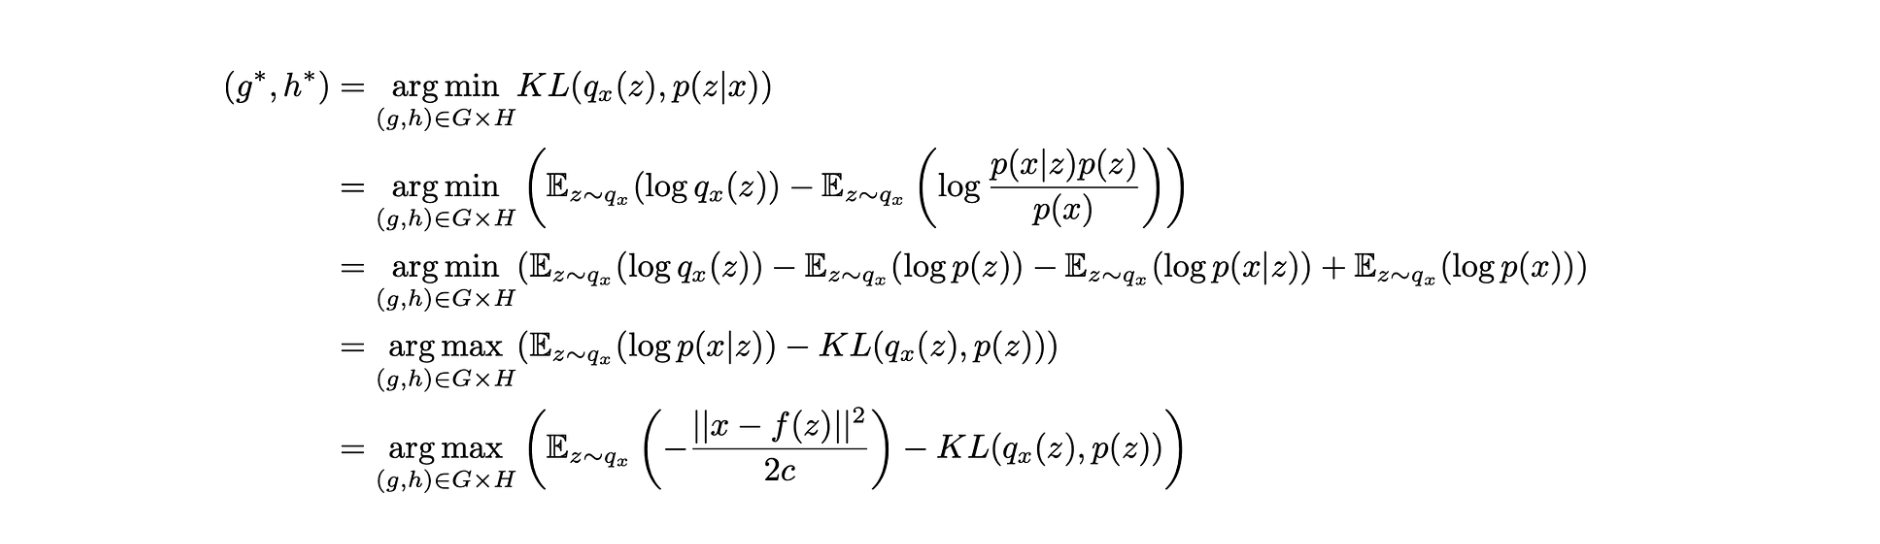

Thus, we are looking for optimal f*, g* and h* such that

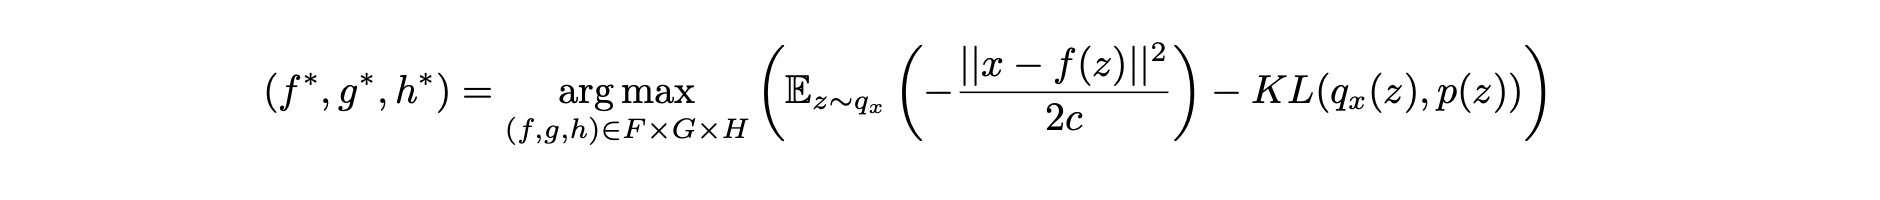

Now, we have set a probabilistic model that depends on three functions, f, g and h, the optimisation problem is to solve in order to get f*, g* and h* that give the optimal encoding-decoding scheme with this model.

We express f, g and h as neural networks. Thus, F, G and H correspond respectively to the families of functions defined by the networks architectures and the optimisation is done over the parameters of these networks.

In practice, g and h are not defined by two completely independent networks but share a part of their architecture and their weights so that we have

g(x) = g2(g1(x))      h(x) = h2(h1(x))        g1(x) = h1(x)

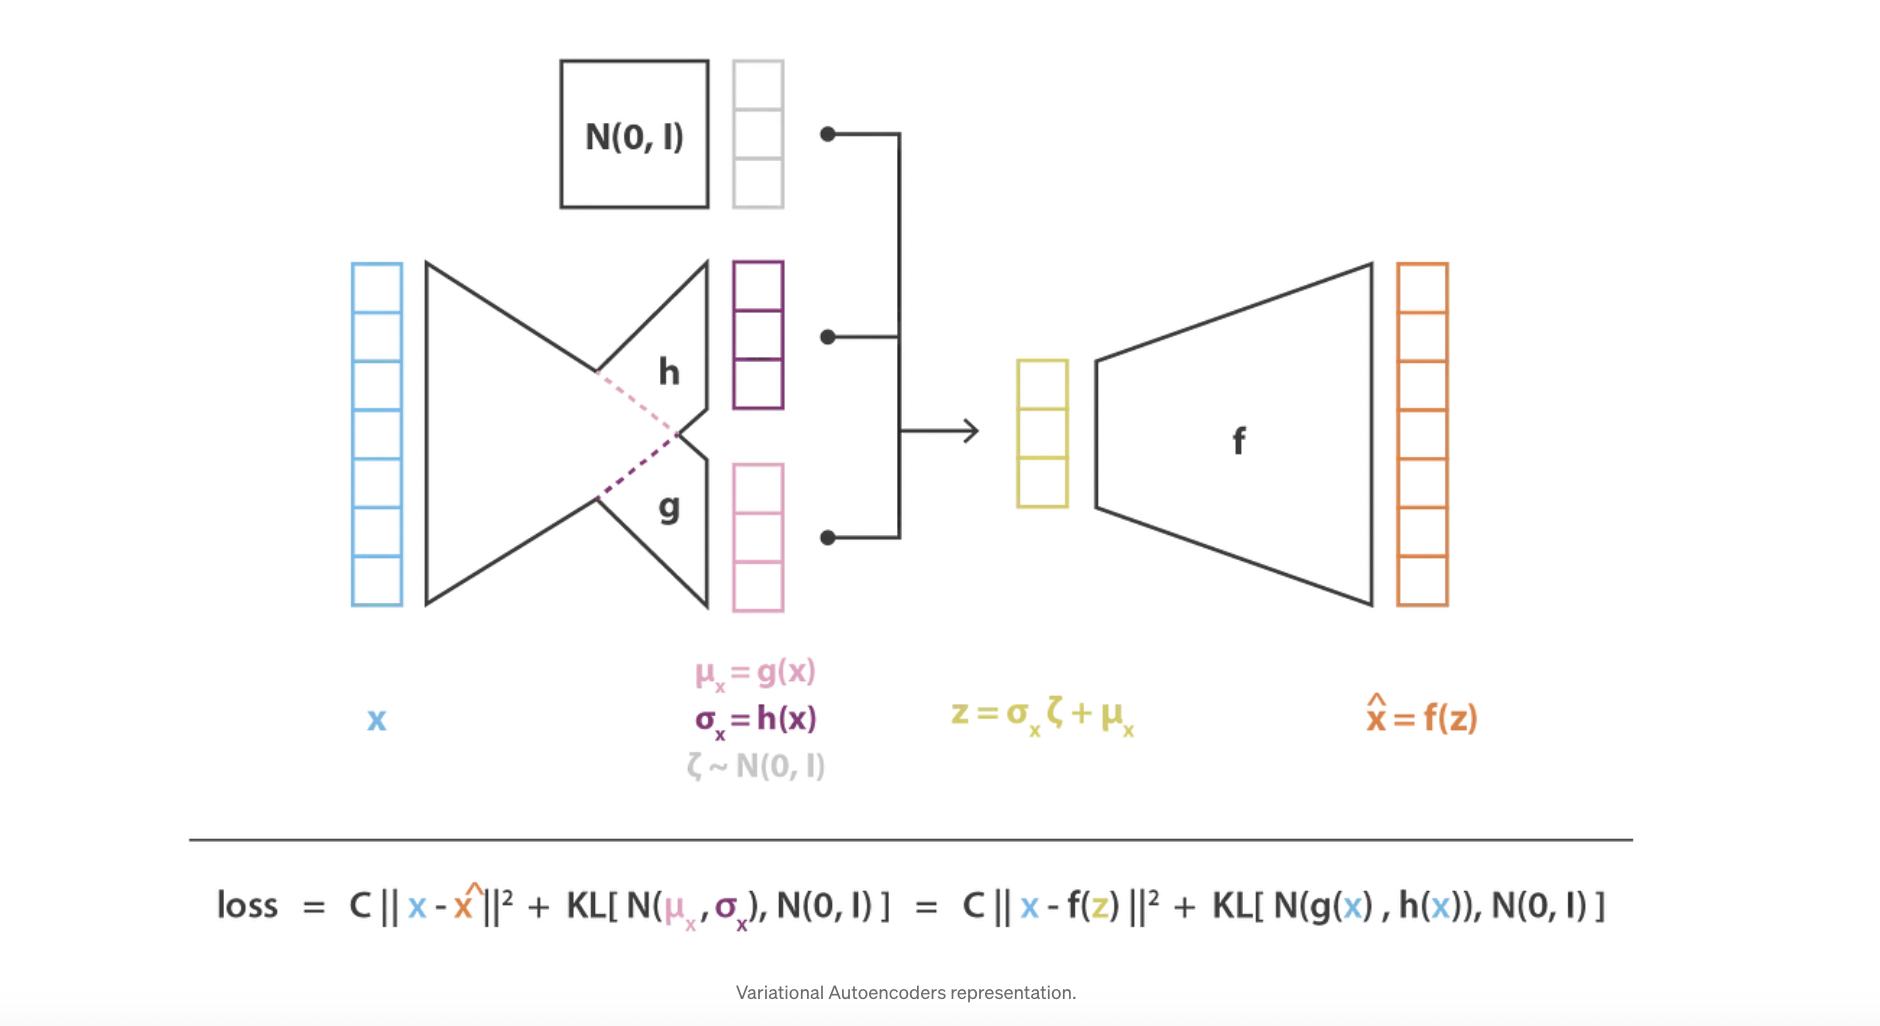

In [1]:
import tensorflow as tf
import numpy as np

(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the input data
x_train = x_train / 255.
# Reshape the input data to have an additional batch dimension
x_train = x_train.reshape((-1, 28*28))
x_test = x_test.reshape((-1, 28*28))

In [2]:
input_dim = 28*28
hidden_dim = 512
latent_dim = 128

In [3]:
encoder_input = tf.keras.Input(shape=(input_dim,))
encoder_hidden = tf.keras.layers.Dense(hidden_dim, activation='relu')(encoder_input)
latent = tf.keras.layers.Dense(latent_dim)(encoder_hidden)
encoder = tf.keras.Model(encoder_input, latent)

In [4]:
decoder_input = tf.keras.Input(shape=(latent_dim,))
decoder_hidden = tf.keras.layers.Dense(hidden_dim, activation='relu')(decoder_input)
decoder_output = tf.keras.layers.Dense(input_dim)(decoder_hidden)
decoder = tf.keras.Model(decoder_input, decoder_output)

In [5]:
inputs = tf.keras.Input(shape=(input_dim,))
latent = encoder(inputs)
outputs = decoder(latent)
vae = tf.keras.Model(inputs, outputs)

In [6]:
len(x_train)

60000

In [8]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

num_epochs = 10
for epoch in range(num_epochs):

  print(epoch)

  for x in x_train[:1000]:

    x = x[tf.newaxis, ...]

    with tf.GradientTape() as tape:

      reconstructed = vae(x)
      loss = loss_fn(x, reconstructed)


    grads = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, vae.trainable_variables))

  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.numpy():.4f}')

0
Epoch 1/10, Loss: 0.4426
1
Epoch 2/10, Loss: 0.4073
2
Epoch 3/10, Loss: 0.3984
3
Epoch 4/10, Loss: 0.3638
4
Epoch 5/10, Loss: 0.3123
5
Epoch 6/10, Loss: 0.3035
6
Epoch 7/10, Loss: 0.3128
7
Epoch 8/10, Loss: 0.3377
8
Epoch 9/10, Loss: 0.3381
9
Epoch 10/10, Loss: 0.3734


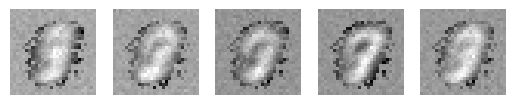

In [9]:
# Generate samples
latent_samples = tf.random.normal(shape=(5, latent_dim))
generated_samples = decoder(latent_samples)

# Plot the generated samples
import matplotlib.pyplot as plt

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(generated_samples[i].numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()

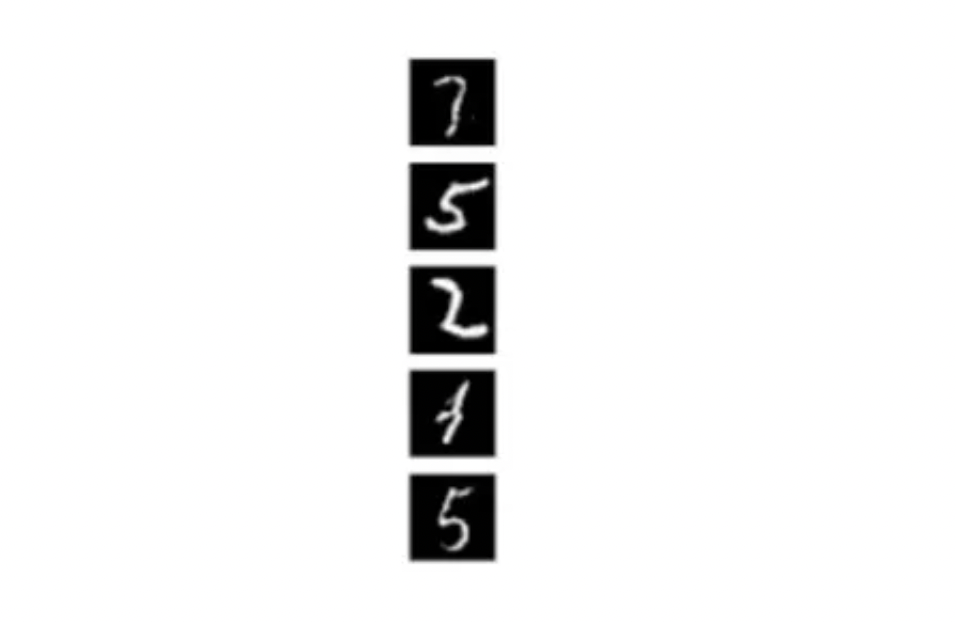

In [ ]:
import tensorflow as tf
from sklearn.manifold import TSNE


latent_vectors = encoder(x_train).numpy()


latent_2d = TSNE(n_components=2).fit_transform(latent_vectors)

# Ploting latent space
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.show()

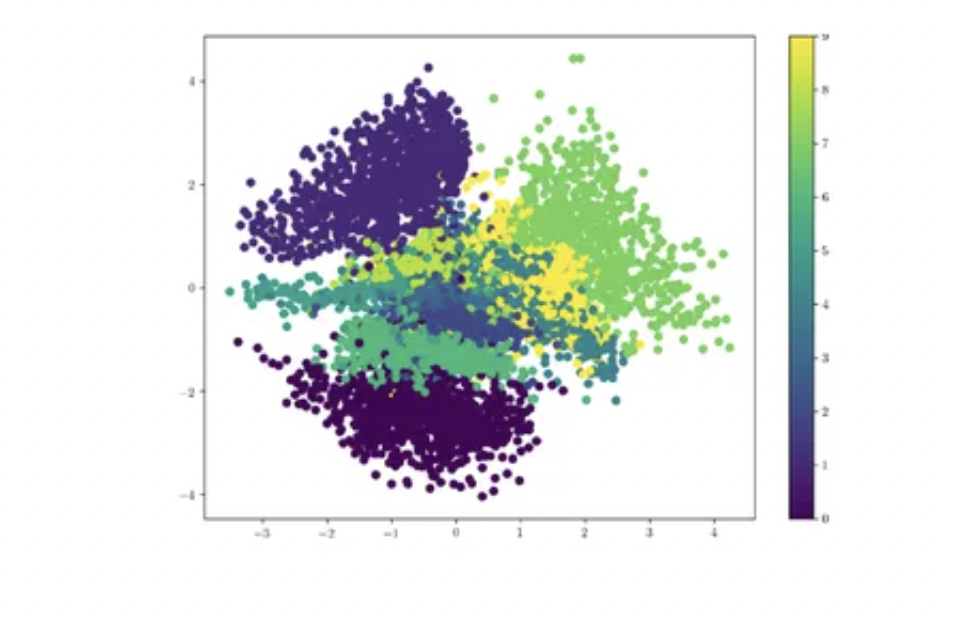

*Credits:

https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

https://www.analyticsvidhya.com/blog/2023/07/an-overview-of-variational-autoencoders/